<a href="https://colab.research.google.com/github/devan1510/devan1510/blob/main/transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install tensorflow_hub
!pip install tensorflow_hub

In [ ]:
# imports for the project
import numpy as np
import cv2# to resize images
import PIL.Image as Image
import os
import matplotlib.pylab as plt

# tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# prepare a model
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4")(x)),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# read the dataset
file_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
with open(file_path, 'r') as f:
    image_labels = f.read().splitlines()

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
import pathlib
data_dir= pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
list(data_dir.glob("*/*.jpg"))[:5]

[PosixPath('datasets/flower_photos/daisy/7416083788_fcb4c4f27e_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/14307766919_fac3c37a6b_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/3695826945_9f374e8a00_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/301964511_fab84ea1c1.jpg'),
 PosixPath('datasets/flower_photos/daisy/7358085448_b317d11cd5.jpg')]

In [ ]:
# count the number of images
image_count= len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


In [ ]:
roses= list(data_dir.glob("roses/*"))
roses[:5]

[PosixPath('datasets/flower_photos/roses/19153732586_9de58c8f53_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4764674741_82b8f93359_n.jpg'),
 PosixPath('datasets/flower_photos/roses/475947979_554062a608_m.jpg'),
 PosixPath('datasets/flower_photos/roses/14880561916_79aeb812fd_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2713683760_d98cd2a05b_m.jpg')]

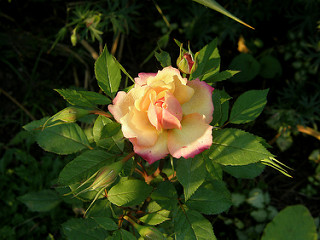

In [ ]:
# upload an image
Image.open(str(roses[1]))

In [ ]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
X= []
y= []
for flower_name,images in flowers_images_dict.items():
  for image in images:
    img= cv2.imread(str(image))
    resized_img= cv2.resize(img,(224,224))
    X.append(resized_img)
    y.append(flowers_labels_dict[flower_name])

In [ ]:
X= np.array(X)
y= np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= .2)

In [ ]:
# normalise the size of the images for efficient training
X_train= X_train/255
X_test= X_test/255

In [ ]:
X[0].shape

(224, 224, 3)

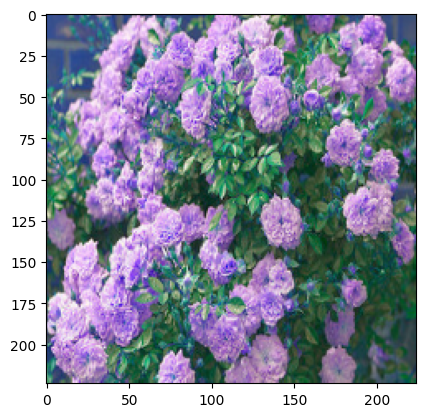

In [ ]:
plt.imshow(X[0])

In [ ]:
x0_resized= cv2.resize(X[0],image_shape)
x1_resized= cv2.resize(X[1],image_shape)
x2_resized= cv2.resize(X[2],image_shape)

In [ ]:
# use a pretrained feature extraction model from tensorflow hub
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model= hub.KerasLayer(feature_extractor_model,input_shape= (224,224,3),trainable= False)

In [ ]:
# build a model and get a summary
transfer_model= tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:pretrained_model(x)),
    tf.keras.layers.Dense(5)
])
transfer_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
transfer_model.compile(optimizer= "adam",
                       loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics= ["accuracy"])

In [ ]:
# fit the model to training data
transfer_model.fit(X_train,y_train,epochs= 2)

Epoch 1/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5894 - loss: 1.0739
Epoch 2/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8635 - loss: 0.4147


In [ ]:
# evaluate the model
loss,accuracy =transfer_model.evaluate(X_test,y_test)